In [3]:
pip install ktrain

     |████████████████████████████████| 25.2MB 127kB/s 
     |████████████████████████████████| 421.8MB 24kB/s 
     |████████████████████████████████| 983kB 32.5MB/s 
     |████████████████████████████████| 245kB 44.7MB/s 
     |████████████████████████████████| 573kB 34.1MB/s 
     |████████████████████████████████| 471kB 42.2MB/s 
     |████████████████████████████████| 450kB 40.1MB/s 
     |████████████████████████████████| 3.9MB 32.1MB/s 
     |████████████████████████████████| 1.0MB 39.5MB/s 
     |████████████████████████████████| 3.7MB 38.7MB/s 
     |████████████████████████████████| 890kB 33.2MB/s 
  Created wheel for ktrain: filename=ktrain-0.14.2-cp36-none-any.whl size=25245177 sha256=10dd70bc387913727735df9336216f1771cf8bee7040812fc6710dc89f455dee
  Stored in directory: /root/.cache/pip/wheels/d2/52/11/747feea8ec83ff98a49d81dd1115a67ceb7b4a4ed0f8a37efe
  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=7d4950bb939b0a25d7ab920e9af

In [1]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score
import os
import csv
import numpy as np
import pandas as pd
from numpy.random import RandomState
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import StackingClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.feature_extraction.text import CountVectorizer
import ktrain
from ktrain import text
import tensorflow as tf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rishab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
TRAIN_DATA_FILE = "training_data.csv"
TEST_DATA_FILE="test_data.csv"

In [0]:
train_data=pd.read_csv(TRAIN_DATA_FILE)
test_data=pd.read_csv(TEST_DATA_FILE)
test_labels=pd.read_csv('sample_submission.csv')

In [24]:
(x_train, y_train), (x_test, y_test), preproc=text.texts_from_df(train_data,
                                                                 text_column='text',
                                                                 label_columns=['labels'],
                                                                 maxlen=150,
                                                                 preprocess_mode='bert')

preprocessing train...
language: en


preprocessing test...
language: en


In [25]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6,)

Is Multi-Label? False
maxlen is 150
done.


In [11]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 4739 samples
Epoch 1/1024
4739/4739 [==============================] - 318s 67ms/sample - loss: 0.6799 - accuracy: 0.5807
Epoch 2/1024
2688/4739 [================>.............] - ETA: 2:08 - loss: 1.1503 - accuracy: 0.5379

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


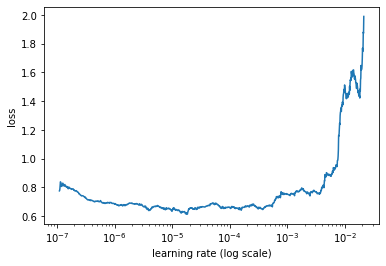

In [12]:
learner.lr_plot()

In [0]:
counter_weight={}
weights=train_data['labels'].value_counts()

for n,wght in enumerate(weights):
    counter_weight[n]=(np.max(weights)/wght)

In [9]:
weights=train_data['labels'].value_counts()
weights

1    3235
0    2031
Name: labels, dtype: int64

In [13]:
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
Train on 4739 samples, validate on 527 samples
4739/4739 [==============================] - 307s 65ms/sample - loss: 0.6289 - accuracy: 0.6527 - val_loss: 0.5738 - val_accuracy: 0.6964


In [26]:
learner.autofit(2e-5,4,early_stopping=1)



begin training using triangular learning rate policy with max lr of 2e-05...
Train on 4739 samples, validate on 527 samples
Epoch 1/4
4739/4739 [==============================] - 326s 69ms/sample - loss: 0.6394 - accuracy: 0.6417 - val_loss: 0.5817 - val_accuracy: 0.6888
Epoch 2/4
4739/4739 [==============================] - 305s 64ms/sample - loss: 0.5673 - accuracy: 0.7141 - val_loss: 0.5719 - val_accuracy: 0.7059
Epoch 3/4
4739/4739 [==============================] - 302s 64ms/sample - loss: 0.4734 - accuracy: 0.7843 - val_loss: 0.6210 - val_accuracy: 0.7021
Epoch 00003: early stopping
Weights from best epoch have been loaded into model.


In [0]:
predictor=ktrain.get_predictor(learner.model,preproc)

In [0]:
data=test_data['text'].values.tolist()

In [29]:
predictions=predictor.predict(data)

In [0]:
pred_df=pd.DataFrame({'labels':predictions})
pred_df.to_csv('submission5.csv',index=False)